---
title: "Word alignment with multilingual BERT: from subwords to lexicons"
subtitle: "Multilingual NLP -- Lab 2"
author: "Philippos Triantafyllou"
date-modified: last-modified
date-format: long
lang: en
format:
    pdf:
        pdf-engine: lualatex
        documentclass: scrartcl
        fontsize: 16pt
        papersize: A3
        toccolor: blue
        classoption: 
            - "DIV=12"
            - "parskip=relative"
            - "titlepage=false"
        code-block-border-left: MediumBlue
        code-block-bg: WhiteSmoke
        template-partials:
            - "../_pandoc/doc-class.tex"
            - "../_pandoc/toc.tex"
            - "../_pandoc/before-title.tex"
toc: true
toc-depth: 3
number-depth: 1
number-sections: true
highlight-style: github
fig-cap-location: top
execute:
  echo: false
  output: false
embed-resources: true
---

## Selecting languages

We will load data form `sentence-transformers/parallel-sentences-jw300` and bilingual pairs from `MUSE`.

We select 5 languages that are well represented in the training of `mBERT` and 5 others that are either less represented or absent (the only language that is completely absent from `mBERT` is Kurdish). All the languages also have a bilingual lexicon from `MUSE` that we will use for the CCA.

In [1]:
# Disable useless logging

import logging
logging.basicConfig(level=logging.INFO)

from transformers import logging
logging.set_verbosity_error()

from datasets import disable_progress_bars
disable_progress_bars()

In [2]:
#| echo: true

# (language, code, link_to_MUSE)
langs = [
    ("albanian",    "sq",   "https://dl.fbaipublicfiles.com/arrival/dictionaries/en-sq.0-5000.txt"),
    ("arabic",      "ar",   "https://dl.fbaipublicfiles.com/arrival/dictionaries/en-ar.0-5000.txt"),
    ("french",      "fr",   "https://dl.fbaipublicfiles.com/arrival/dictionaries/en-fr.0-5000.txt"),
    ("german",      "de",   "https://dl.fbaipublicfiles.com/arrival/dictionaries/en-de.0-5000.txt"),
    ("greek",       "el",   "https://dl.fbaipublicfiles.com/arrival/dictionaries/en-el.0-5000.txt"),
    ("hindi",       "hi",   "https://dl.fbaipublicfiles.com/arrival/dictionaries/en-hi.0-5000.txt"),
    ("japanese",    "ja",   "https://dl.fbaipublicfiles.com/arrival/dictionaries/en-ja.0-5000.txt"),
    ("macedonian",  "mk",   "https://dl.fbaipublicfiles.com/arrival/dictionaries/en-mk.0-5000.txt"),
    ("persian",     "fa",   "https://dl.fbaipublicfiles.com/arrival/dictionaries/en-fa.0-5000.txt"),
    ("thai",        "th",   "https://dl.fbaipublicfiles.com/arrival/dictionaries/en-th.0-5000.txt")
]

Loading the datasets.

In [3]:
#| echo: true

import requests
from datasets import load_dataset

def install_datasets(langs):
    corpora = {}

    # Iterate through each language definition (name, ISO code, lexicon URL)
    for lang, code, links in langs:
        print(f"Processing {lang}...")
        corpora[lang] = {}
        print(f"\tLoading pairs...")

        # Load parallel English–target-language sentence pairs from JW300
        data = load_dataset(
            "sentence-transformers/parallel-sentences-jw300",
            f"en-{code}",
            split="train"
        )
        print(f"\tLoaded JW300 for {lang}")

        corpora[lang]['pairs'] = (
            data
            # Load up to 5,000 parallel sentence pairs
            .take(5000) # type: ignore
            .map(
                # Clean zero-width Unicode chars
                lambda x: {
                    'english': x['english'].replace('\u200b', '').replace('\u200f', '').replace('\u200c', ''),
                    'non_english': x['non_english'].replace('\u200b', '').replace('\u200f', '').replace('\u200c', '')
                }
            )
            # Drop any pair where either side becomes empty after cleaning
            .filter(
                lambda x: x['english'].strip() and x['non_english'].strip()
            )
        )

        # Report how many valid parallel pairs remain after filtering
        print(f"\tKept {len(corpora[lang]['pairs'])} aligned sentence pairs")

        print(f"\tLoading lexicons...")

        # Download and decode the lexicon text file
        text = requests.get(links).content.decode("utf-8", errors="ignore")

        # Parse tab-separated lexicons if tabs are present
        if '\t' in text:
            lexicon = [
                tuple(line.split('\t', 1))
                for line in text.splitlines()
                if line.strip() and '\t' in line
            ]
        # Otherwise parse whitespace-separated lexicons (French and German)
        else:
            lexicon = [
                tuple(line.split(None, 1))
                for line in text.splitlines()
                if line.strip()
            ]

        corpora[lang]["lexicon"] = lexicon
    return corpora

In [ ]:
import os
from datasets import Dataset

def save_datasets(corpora, data_folder="data"):
    os.makedirs(data_folder, exist_ok=True)
    
    for lang, content in corpora.items():
        lang_folder = os.path.join(data_folder, lang)
        os.makedirs(lang_folder, exist_ok=True)
        
        # Save pairs as jsonl
        pairs_path = os.path.join(lang_folder, "pairs.jsonl")
        content['pairs'].to_json(pairs_path)
        
        # Save lexicon as text file
        lexicon_path = os.path.join(lang_folder, "lexicon.txt")
        with open(lexicon_path, 'w', encoding='utf-8') as f:
            for src, tgt in content['lexicon']:
                f.write(f"{src}\t{tgt}\n")

In [ ]:
def load_datasets(langs, data_folder="data"):
    corpora = {}
    
    for lang, _, _ in langs:
        lang_folder = os.path.join(data_folder, lang)
        corpora[lang] = {}
        
        # Load pairs
        pairs_path = os.path.join(lang_folder, "pairs.jsonl")
        corpora[lang]['pairs'] = Dataset.from_json(pairs_path)
        
        # Load lexicon
        lexicon_path = os.path.join(lang_folder, "lexicon.txt")
        with open(lexicon_path, 'r', encoding='utf-8') as f:
            lexicon = [tuple(line.strip().split('\t', 1)) for line in f if line.strip()]
        corpora[lang]['lexicon'] = lexicon
    
    return corpora

In [6]:
#| output: true
#| eval: false

data = install_datasets(langs)
save_datasets(data)

Processing albanian...
	Loading pairs...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

en-sq/train-00000-of-00001.parquet:   0%|          | 0.00/83.8M [00:00<?, ?B/s]

	Loaded JW300 for albanian
	Kept 4928 aligned sentence pairs
	Loading lexicons...
Processing arabic...
	Loading pairs...


en-ar/train-00000-of-00001.parquet:   0%|          | 0.00/71.7M [00:00<?, ?B/s]

	Loaded JW300 for arabic
	Kept 4844 aligned sentence pairs
	Loading lexicons...
Processing french...
	Loading pairs...


en-fr/train-00000-of-00001.parquet:   0%|          | 0.00/297M [00:00<?, ?B/s]

	Loaded JW300 for french
	Kept 4773 aligned sentence pairs
	Loading lexicons...
Processing german...
	Loading pairs...


en-de/train-00000-of-00001.parquet:   0%|          | 0.00/268M [00:00<?, ?B/s]

	Loaded JW300 for german
	Kept 4942 aligned sentence pairs
	Loading lexicons...
Processing greek...
	Loading pairs...


en-el/train-00000-of-00002.parquet:   0%|          | 0.00/173M [00:00<?, ?B/s]

en-el/train-00001-of-00002.parquet:   0%|          | 0.00/174M [00:00<?, ?B/s]

	Loaded JW300 for greek
	Kept 4618 aligned sentence pairs
	Loading lexicons...
Processing hindi...
	Loading pairs...


en-hi/train-00000-of-00001.parquet:   0%|          | 0.00/86.8M [00:00<?, ?B/s]

	Loaded JW300 for hindi
	Kept 4053 aligned sentence pairs
	Loading lexicons...
Processing japanese...
	Loading pairs...


en-ja/train-00000-of-00002.parquet:   0%|          | 0.00/142M [00:00<?, ?B/s]

en-ja/train-00001-of-00002.parquet:   0%|          | 0.00/136M [00:00<?, ?B/s]

	Loaded JW300 for japanese
	Kept 4557 aligned sentence pairs
	Loading lexicons...
Processing macedonian...
	Loading pairs...


en-mk/train-00000-of-00001.parquet:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

	Loaded JW300 for macedonian
	Kept 4890 aligned sentence pairs
	Loading lexicons...
Processing persian...
	Loading pairs...


en-fa/train-00000-of-00001.parquet:   0%|          | 0.00/40.4M [00:00<?, ?B/s]

	Loaded JW300 for persian
	Kept 4511 aligned sentence pairs
	Loading lexicons...
Processing thai...
	Loading pairs...


en-th/train-00000-of-00001.parquet:   0%|          | 0.00/135M [00:00<?, ?B/s]

	Loaded JW300 for thai
	Kept 4167 aligned sentence pairs
	Loading lexicons...


In [7]:
data = load_datasets(langs)

In [8]:
for lang, corpora in data.items():
    print(f"For {lang}:")
    for keys, vals in corpora.items():
        print(f"{keys} ({type(vals)})")
        print(f"{vals[:5]}")
    print()

For albanian:
pairs (<class 'datasets.arrow_dataset.Dataset'>)
{'english': ['Page Two', '1945 - 1995 What Have We Learned?', '3 - 14', 'Fifty years have passed since the end of World War II.', 'In what ways has humankind progressed?'], 'non_english': ['Faqja dy', '1945 - 1995 Çfarë kemi mësuar?', '3 - 14', 'Kanë kaluar pesëdhjetë vjet që nga mbarimi i Luftës II Botërore.', 'Në cilat fusha ka bërë progres njeriu?']}
lexicon (<class 'list'>)
[('and', 'dhe'), ('was', 'ishte'), ('for', 'për'), ('for', 'per'), ('that', 'që')]

For arabic:
pairs (<class 'datasets.arrow_dataset.Dataset'>)
{'english': ['Perhaps you have asked yourself this question, as well as others: “How Can I Say No to Premarital Sex? ”', '“ Why Do I Get So Depressed? ”', 'These are chapter titles in the new book Questions Young People Ask  — Answers That Work.', 'A youth from San Antonio, Texas, wrote: “I really enjoyed chapter 36, ‘ How Can I Control My TV Viewing Habits? ’', 'It will really help me. I am a compulsive TV 

## Obtaining embeddings with `mBERT`

For the selected languages, obtain the `mBERT` representations for all these sentences, aggregating subword embeddings in order to reconstruct word-level vectors.

In [9]:
#| echo: true

from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-multilingual-cased")
model = AutoModel.from_pretrained("google-bert/bert-base-multilingual-cased")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

The pipeline is as follows:

- A function takes care to extract the embeddings for a list of sentences in a given language.
- A second function iterates over all languages in the dataset, calling the first function for each language and storing the results.
- Finally, we save the extracted embeddings to disk for later use.

Function to extract embeddings.

In [ ]:
#| echo: true

import torch

def get_word_embeddings(sentences, tokenizer, model, batch_size=16, device=None):
    # Device detection
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.to(device)
    model.eval()

    all_results = []
    total_sentences = len(sentences)
    
    # Process in batches
    for batch_idx in range(0, total_sentences, batch_size):
        batch = sentences[batch_idx:batch_idx + batch_size]

        # Tokenize batch
        encoded = tokenizer(
            list(batch),
            return_tensors='pt',
            padding=True,
            truncation=True,
            max_length=512,
            add_special_tokens=True
        )

        # Move to device
        input_ids = encoded['input_ids'].to(device)
        attention_mask = encoded['attention_mask'].to(device)

        # Get embeddings
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            embeddings = outputs.last_hidden_state # [batch_size, seq_len, hidden_size]

        # Process each sentence in the batch
        for idx_in_batch, sentence in enumerate(batch):
            word_ids = encoded.word_ids(batch_index=idx_in_batch)
            sent_embeddings = embeddings[idx_in_batch]

            # Group tokens by word_id
            word_to_token_indices = {}
            for token_idx, word_id in enumerate(word_ids):
                if word_id is not None:
                    if word_id not in word_to_token_indices:
                        word_to_token_indices[word_id] = []
                    word_to_token_indices[word_id].append(token_idx)

            # Aggregate embeddings (mean)
            word_embeddings = []
            for word_id in sorted(word_to_token_indices.keys()):
                token_indices = word_to_token_indices[word_id]
                token_embs = sent_embeddings[token_indices]
                word_emb = token_embs.mean(dim=0)

                word_embeddings.append({
                    'word_id': word_id,
                    'embedding': word_emb.cpu().numpy(),
                    'num_tokens': len(token_indices)
                })

            all_results.append({
                'sentence': sentence,
                'word_embeddings': word_embeddings,
                'num_words': len(word_embeddings)
            })

        # Progress
        processed = min(batch_idx + batch_size, total_sentences)
        progress_pct = (processed / total_sentences) * 100
        print(f"\tProgress: {processed}/{total_sentences} ({progress_pct:.1f}%)", end='\r')

        # Memory management
        if device.type == 'cpu' and batch_idx % (batch_size * 20) == 0:
            import gc
            gc.collect()

        if device.type == 'cuda' and batch_idx % (batch_size * 10) == 0:
            torch.cuda.empty_cache()

    print()
    return all_results

Function to process all languages in the dataset.

In [11]:
#| echo: true

def process_all_languages(data, tokenizer, model, batch_size=16, device=None, save_dir=None):
    import time
    
    embeddings_by_language = {}
    total_start_time = time.time()
    
    for lang_idx, (lang, corpora) in enumerate(data.items(), 1):
        print(f"\n{'='*70}")
        print(f"[{lang_idx}/{len(data)}] Processing {lang.upper()}")
        print('='*70)
        
        embeddings_by_language[lang] = {}
        
        if 'pairs' in corpora:
            english_sentences = corpora['pairs']['english']
            non_english_sentences = corpora['pairs']['non_english']
            
            # Process English
            print(f"\nProcessing English sentences ({len(english_sentences)} total)...")
            start_time = time.time()
            embeddings_by_language[lang]['english'] = get_word_embeddings(
                english_sentences, tokenizer, model, 
                batch_size=batch_size, device=device
            )
            english_time = time.time() - start_time
            print(f"\tCompleted in {english_time:.2f} seconds")
            
            # Process non-English
            print(f"\nProcessing {lang.capitalize()} sentences ({len(non_english_sentences)} total)...")
            start_time = time.time()
            embeddings_by_language[lang]['non_english'] = get_word_embeddings(
                non_english_sentences, tokenizer, model, 
                batch_size=batch_size, device=device
            )
            non_english_time = time.time() - start_time
            print(f"\tCompleted in {non_english_time:.2f} seconds")
            
            # Summary
            print(f"\n{lang.upper()} Summary:")
            print(f"\tEnglish: {len(embeddings_by_language[lang]['english'])} sentences")
            print(f"\t{lang.capitalize()}: {len(embeddings_by_language[lang]['non_english'])} sentences")
            print(f"\tTotal time: {english_time + non_english_time:.2f} seconds")
            
            # Save intermediate results
            if save_dir:
                import pickle
                import os
                os.makedirs(save_dir, exist_ok=True)
                
                filepath = os.path.join(save_dir, f'embeddings_{lang}.pkl')
                with open(filepath, 'wb') as f:
                    pickle.dump(embeddings_by_language[lang], f)
                print(f"\tSaved to {filepath}")
    
    total_time = time.time() - total_start_time
    print(f"\n{'='*70}")
    print(f"ALL LANGUAGES PROCESSED!")
    print(f"Total time: {total_time:.2f} seconds ({total_time/60:.2f} minutes)")
    print('='*70)
    
    return embeddings_by_language

In [12]:
#| echo: true
#| eval: false

embeddings_by_language = process_all_languages(
    data, 
    tokenizer, 
    model, 
    batch_size=16,
    device=None,
    save_dir='./embeddings'
)


[1/10] Processing ALBANIAN

Processing English sentences (4928 total)...
	Progress: 4928/4928 (100.0%)
	Completed in 15.18 seconds

Processing Albanian sentences (4928 total)...
	Progress: 4928/4928 (100.0%)
	Completed in 16.46 seconds

ALBANIAN Summary:
	English: 4928 sentences
	Albanian: 4928 sentences
	Total time: 31.63 seconds
	Saved to ./embeddings/embeddings_albanian.pkl

[2/10] Processing ARABIC

Processing English sentences (4844 total)...
	Progress: 4844/4844 (100.0%)
	Completed in 13.99 seconds

Processing Arabic sentences (4844 total)...
	Progress: 4844/4844 (100.0%)
	Completed in 12.94 seconds

ARABIC Summary:
	English: 4844 sentences
	Arabic: 4844 sentences
	Total time: 26.93 seconds
	Saved to ./embeddings/embeddings_arabic.pkl

[3/10] Processing FRENCH

Processing English sentences (4773 total)...
	Progress: 4773/4773 (100.0%)
	Completed in 14.68 seconds

Processing French sentences (4773 total)...
	Progress: 4773/4773 (100.0%)
	Completed in 16.95 seconds

FRENCH Summary

In [13]:
import os
import pickle

def load_embeddings(langs, embeddings_folder="embeddings"):
    embeddings_by_language = {}

    for idx, (lang, _, _) in enumerate(langs, 1):
        print(f"\n[{idx}/{len(langs)}] Loading embeddings for '{lang}'")

        embeddings_by_language[lang] = {}

        # Path to saved embeddings for this language
        filepath = os.path.join(embeddings_folder, f"embeddings_{lang}.pkl")

        # Load embeddings from disk
        with open(filepath, "rb") as f:
            embeddings_by_language[lang] = pickle.load(f)
            keys = ", ".join(embeddings_by_language[lang].keys())
            print(f"Loaded successfully (keys: {keys})")

    print("\nAll embeddings loaded.")
    return embeddings_by_language

In [14]:
embeddings_by_language = load_embeddings(langs, embeddings_folder="./embeddings")


[1/10] Loading embeddings for 'albanian'
Loaded successfully (keys: english, non_english)

[2/10] Loading embeddings for 'arabic'
Loaded successfully (keys: english, non_english)

[3/10] Loading embeddings for 'french'
Loaded successfully (keys: english, non_english)

[4/10] Loading embeddings for 'german'
Loaded successfully (keys: english, non_english)

[5/10] Loading embeddings for 'greek'
Loaded successfully (keys: english, non_english)

[6/10] Loading embeddings for 'hindi'
Loaded successfully (keys: english, non_english)

[7/10] Loading embeddings for 'japanese'
Loaded successfully (keys: english, non_english)

[8/10] Loading embeddings for 'macedonian'
Loaded successfully (keys: english, non_english)

[9/10] Loading embeddings for 'persian'
Loaded successfully (keys: english, non_english)

[10/10] Loading embeddings for 'thai'
Loaded successfully (keys: english, non_english)

All embeddings loaded.


Checking that all embeddings have been extracted correctly.

In [15]:
#| echo: true
#| output: true

def validate_word_embeddings(data, embeddings_by_language):
    for lang in data.keys():
        english_embeddings = embeddings_by_language[lang]['english']
        non_english_embeddings = embeddings_by_language[lang]['non_english']

        # Sanity check: sentence-level alignment
        if len(english_embeddings) != len(non_english_embeddings):
            print("FAILED")
            return False

        # Check all sentence embeddings
        for en_sent, non_en_sent in zip(english_embeddings, non_english_embeddings):
            if len(en_sent['word_embeddings']) != en_sent['num_words']:
                return False
            if len(non_en_sent['word_embeddings']) != non_en_sent['num_words']:
                return False

    return print("All embeddings validated successfully.")

validate_word_embeddings(data, embeddings_by_language)

All embeddings validated successfully.


## First alignement method: argmax over cosine similarities

Right now we have one embedding per word. That is, for each example, we have computed a contextualised embedding. Since our goal is to build a lexicon, we need to aggregate these embeddings across all examples.

The simplest way to do this is to average the embeddings for each word in the vocabulary. This way, we obtain a single embedding per word type. But this approach has some drawbacks:

- It ignores the fact that words can have multiple meanings (polysemy).
- It treats all occurrences of a word equally, regardless of context.
- It can be sensitive to outliers, as rare contexts can skew the average.
- It does not capture the full distribution of meanings a word can have.
- It assumes that the average embedding is a good representation of the word's meaning!

The "correct" way to take into account multiple meanings would be to use a sense inventory and cluster the embeddings based on these senses. However, this requires external resources that we currently do not have. Furthermore, even if we had such inventories, how would we know for each occurrence which sense is being used? The contextualised embeddings already capture some of this information, but we would need a way to link them to the senses. For example we could compute the average embedding for each sense from the inventory and then assign each occurrence to the closest sense embedding...

A "better" way to do this given our resources is to use clustering. For each word, we can cluster its contextualised embeddings and then use the centroids of these clusters as the word's representations. This way, we can capture multiple meanings of a word and reduce the impact of outliers. But this approach also has its challenges. For example, choosing the right number of clusters can be tricky, how can we decide how many senses a word has?

For this exercise, we will stick to the simple averaging method. Either way, it is a good step to start with the simplest method and see if it works well enough for our purposes.

For each language, we will build a lexicon by word type, averaging the embeddings for each word across all its occurrences.

- One function to build the lexicon for a given language.
- A loop to build lexicons for all languages.

We also want to drop all invalid words (punctuation, special tokens, numbers, etc.). We can use a simple regex to do this. We can take advantage of python's `str.isalpha()` method, which checks if a character is alphabetic in any script.

In [16]:
def is_valid_word(w):
    # Drop pure numbers
    if w.isdigit():
        return False
    # Keep only tokens with at least one alphabetic character (any script)
    if not any(ch.isalpha() for ch in w):
        return False
    return True

In [17]:
#| echo: true

import numpy as np
from collections import defaultdict

def build_lexicon_for_language(embeddings):
    word_to_embeddings = defaultdict(list)

    for sent in embeddings:
        words = sent['sentence'].split()
        word_embs = sent['word_embeddings']

        for w, w_emb in zip(words, word_embs):
            if not is_valid_word(w):
                continue
            w = w.lower()
            word_to_embeddings[w].append(w_emb['embedding'])

    return {
        word: np.mean(np.stack(embs), axis=0)
        for word, embs in word_to_embeddings.items()
    }

In [18]:
#| echo: true

def build_lexicons_for_all_languages(embeddings_by_language):
    lexicons_by_language = {}

    for lang in embeddings_by_language.keys():
        print(f"\nLanguage: {lang}")

        english_lexicon = build_lexicon_for_language(
            embeddings_by_language[lang]['english']
        )
        non_english_lexicon = build_lexicon_for_language(
            embeddings_by_language[lang]['non_english']
        )

        lexicons_by_language[lang] = {
            'english': english_lexicon,
            'non_english': non_english_lexicon
        }

        # Print unique word types
        print(f"English word types ({len(english_lexicon)}):")

        print(f"Non-English word types ({len(non_english_lexicon)}):")

    return lexicons_by_language

In [19]:
#| output: true

emb_lexicons_by_language = build_lexicons_for_all_languages(embeddings_by_language)


Language: albanian
English word types (13906):
Non-English word types (17797):

Language: arabic
English word types (13483):
Non-English word types (18304):

Language: french
English word types (14164):
Non-English word types (16312):

Language: german
English word types (13717):
Non-English word types (17397):

Language: greek
English word types (14163):
Non-English word types (18510):

Language: hindi
English word types (13702):
Non-English word types (9297):

Language: japanese
English word types (13482):
Non-English word types (9682):

Language: macedonian
English word types (12985):
Non-English word types (17234):

Language: persian
English word types (10663):
Non-English word types (8414):

Language: thai
English word types (14605):
Non-English word types (5754):


In [20]:
#| echo: true
#| output: true

def validate_lexicons(embeddings_by_language, lexicons_by_language):
    for lang in embeddings_by_language.keys():
        for side in ['english', 'non_english']:
            lexicon = lexicons_by_language[lang][side]

            # Check dimensional consistency
            dims = {v.shape for v in lexicon.values()}
            if len(dims) != 1:
                return False

            # Check lexicon size vs total tokens
            total_tokens = sum(
                len(s['word_embeddings'])
                for s in embeddings_by_language[lang][side]
            )
            if len(lexicon) > total_tokens:
                return False

    return True

validate_lexicons(embeddings_by_language, emb_lexicons_by_language)

True

Right now we have embeddings for each "word type" in each language, but we have included whole sentences that also contain punctuation marks and special tokens. We need to filter these out to keep only valid words. We can use a simple regex to do this.

Now we can build a cosine similarity matrix for each language between the English and non-English lexicons.

In [21]:
#| echo: true

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def build_cosine_similarity_matrix(lexicon_non_english, lexicon_english):
    # Extract word lists
    non_en_words = list(lexicon_non_english.keys())
    en_words = list(lexicon_english.keys())

    # Stack embeddings into matrices
    non_en_vectors = np.stack([lexicon_non_english[w] for w in non_en_words])
    en_vectors = np.stack([lexicon_english[w] for w in en_words])

    # Cosine similarity: rows = non-English, columns = English
    sim_matrix = cosine_similarity(non_en_vectors, en_vectors)

    return sim_matrix, non_en_words, en_words

In [ ]:
#| echo: true

similarity_matrices = {}

for lang, lexicons in emb_lexicons_by_language.items():
    sim_matrix, non_en_words, en_words = build_cosine_similarity_matrix(
        lexicons['non_english'],
        lexicons['english']
    )

    similarity_matrices[lang] = {
        'matrix': sim_matrix,
        'non_english_words': non_en_words,
        'english_words': en_words
    }

We can now build lexicons for all languages.

In [23]:
#| echo: true

def build_lexicon(similarity_matrices, k=1):
    lexicons = {}

    for lang, sim_data in similarity_matrices.items():
        sim_matrix = sim_data['matrix']
        non_en_words = sim_data['non_english_words']
        en_words = sim_data['english_words']

        lexicon = {}
        for i, non_en_word in enumerate(non_en_words):
            sims = sim_matrix[i]

            if k == 1:
                best_idx = int(np.argmax(sims))
                lexicon[non_en_word] = [en_words[best_idx]]
            else:
                topk_idx = np.argsort(sims)[-k:][::-1]
                lexicon[non_en_word] = [en_words[j] for j in topk_idx]

        lexicons[lang] = lexicon

    return lexicons

:::{.callout-note}
There might be a slight encoding problem, the print statements show empty strings for some languages but this is only a problem for latex. The actual strings are there.
:::

In [24]:
#| output: true

argmax_lexicons = build_lexicon(similarity_matrices)

for lang, lexicon in argmax_lexicons.items():
    print(f"\nLanguage: {lang}")
    print(f"Sample lexicon entries:")
    sample_items = list(lexicon.items())[:10]
    for non_en_word, en_word in sample_items:
        print(f"\t{non_en_word} -> {en_word}")


Language: albanian
Sample lexicon entries:
	faqja -> ['photo']
	dy -> ['two']
	çfarë -> ['how']
	kemi -> ['to']
	mësuar? -> ['up.']
	kanë -> ['have']
	kaluar -> ['over']
	pesëdhjetë -> ['four']
	vjet -> ['years']
	që -> ['which']

Language: arabic
Sample lexicon entries:
	كيف -> ['what']
	يمكنني -> ['others']
	ان -> ['that']
	اضبط -> ['addicted']
	عادات -> ['habits']
	مشاهدتي -> ['recordings']
	التلفزيون -> ['radio']
	ربما -> ['day']
	طرحتم -> ['concluded:']
	على -> ['on']

Language: french
Sample lexicon entries:
	éloge -> ['mystery']
	des -> ['of']
	témoins -> ['whom']
	l’œuvre -> ['which']
	de -> ['of']
	prédication -> ['efforts']
	jéhovah -> ['jehovah']
	s’étend -> ['which']
	rapidement. -> ['run']
	cette -> ['this']

Language: german
Sample lexicon entries:
	ein -> ['a']
	wort -> ['word']
	zugunsten -> ['against']
	der -> ['the']
	zeugen -> ['witnesses']
	jehovas -> ['jehovah’s']
	das -> ['is']
	predigtwerk -> ['worldwide']
	dehnt -> ['changed']
	sich -> ['while']

Language: gree

The first results are not great... we can also create "top-k" lexicons to see if the correct translation is among the top candidates. For example k=5.

In [25]:
#| echo: true

top5_lexicons = build_lexicon(similarity_matrices, k=5)

In [26]:
#| output: true

for lang, lexicon in top5_lexicons.items():
    print(f"\nLanguage: {lang}")
    print(f"Sample lexicon entries:")
    sample_items = list(lexicon.items())[:10]
    for non_en_word, en_word in sample_items:
        print(f"\t{non_en_word} -> {en_word}")


Language: albanian
Sample lexicon entries:
	faqja -> ['photo', 'perhaps.', 'mirror', 'ela', 'falter']
	dy -> ['two', 'three', 'four', 'third', 'second']
	çfarë -> ['how', 'did', 'what', 'whether', 'then']
	kemi -> ['to', 'which', 'them', 'and', 'they']
	mësuar? -> ['up.', 'them', 'to', 'it.', 'them.']
	kanë -> ['have', 'least', 'been', 'they', 'had']
	kaluar -> ['over', 'before', 'period', 'long', 'last']
	pesëdhjetë -> ['four', 'five', 'half', 'years', 'ten']
	vjet -> ['years', 'year', 'years.', 'years,', 'ago.']
	që -> ['which', 'that', 'and', 'as', 'they']

Language: arabic
Sample lexicon entries:
	كيف -> ['what', 'how', 'why', 'whether', 'what,']
	يمكنني -> ['others', 'lead', 'learn', 'avoid', 'could']
	ان -> ['that', 'it', 'leave', 'purpose', 'last']
	اضبط -> ['addicted', 'recklessly', 'again', 'addiction', 'raising']
	عادات -> ['habits', 'behavior', 'known', 'hours,', 'them']
	مشاهدتي -> ['recordings', 'reports', 'between', 'friends', 'their']
	التلفزيون -> ['radio', 'middle', '

Looking at the first entries (I consider only the languages I can speak, French, Greek and German), there seems to be an ever so slight improvement when considering the top-5 candidates. What seems to me the case more often than not is that functional words are translated correctly more often than content words. Furthermore, there seems to be a "pooling" effect, where functional words get high similarity scores with content words and thus appear in the top translation-candidate position.

In [27]:
#| echo: true

def sentence_level_hit_at_k(src_sentences, tgt_sentences, lexicon):
    tgt_word_sets = [set(sent.split()) for sent in tgt_sentences]
    accuracies = []

    for src_sent, tgt_word_set in zip(src_sentences, tgt_word_sets):
        hits = 0
        total = 0

        for w in src_sent.split():
            if w not in lexicon:
                continue

            predicted_words = set(lexicon[w])

            if predicted_words & tgt_word_set:
                hits += 1

            total += 1

        accuracies.append(hits / total if total > 0 else 0.0)

    return accuracies

In [28]:
#| echo: true

import pandas as pd

def evaluate_all_languages(data, translation_lexicons):
    rows = []

    for lang, lexicon in translation_lexicons.items():
        accuracies = sentence_level_hit_at_k(
            src_sentences=data[lang]['pairs']['non_english'],
            tgt_sentences=data[lang]['pairs']['english'],
            lexicon=lexicon
        )

        rows.append({
            "language": lang,
            "hit": float(np.mean(accuracies))
        })

    return pd.DataFrame(rows)

In [29]:
results_k1 = evaluate_all_languages(
    data,
    argmax_lexicons
)

results_k5 = evaluate_all_languages(
    data,
    top5_lexicons
)

In [30]:
#| output: true
#| label: results_k1
#| tbl-cap: "Results for argmax evaluation across all languages."

from IPython.core.display import Markdown

Markdown(results_k1.to_markdown(index=False))

| language   |       hit |
|:-----------|----------:|
| albanian   | 0.275912  |
| arabic     | 0.173384  |
| french     | 0.307206  |
| german     | 0.362282  |
| greek      | 0.313626  |
| hindi      | 0.194358  |
| japanese   | 0.245503  |
| macedonian | 0.336152  |
| persian    | 0.156475  |
| thai       | 0.0587208 |

In [31]:
#| output: true
#| label: results_k5
#| tbl-cap: "Results for top 5 evaluation across all languages."

Markdown(results_k5.to_markdown(index=False))

| language   |      hit |
|:-----------|---------:|
| albanian   | 0.493644 |
| arabic     | 0.341002 |
| french     | 0.525088 |
| german     | 0.585316 |
| greek      | 0.530915 |
| hindi      | 0.410893 |
| japanese   | 0.512551 |
| macedonian | 0.551903 |
| persian    | 0.304214 |
| thai       | 0.20467  |

Our evaluation method is "hit at k", meaning that we check if the correct translation is among the top k candidates.

Concretely, we have build lexicons for each language, where each source word is mapped to its top k most similar target words based on cosine similarity of the mean of their contextualized embeddings. One manual way to evaluate is to simply look at those lexicons and see if the translations make sense, but of course, this is not very informative...

What we want to do is to look at the pairs of sentences in our dataset, and for each source word in the sentence, check if its translation (or set of candidate translations) is present in the target sentence. This approach can at least inform us if on the sentence level, our lexicon is able to capture some of the correct translations. This of course completely ignores the alignement, but either way, since languages have different word orders, this is a reasonable first step.

More importantly, this evaluation is flawed in that it does not account for the errors introduced by the alignement method itself. For example, if a source word is aligned to an incorrect target word, say a functional word, if that functional word happens to be present in the target sentence, we would count that as a hit, even though the alignment was incorrect. This means that our evaluation might overestimate the quality of our lexicon.

When we look at the results across all languages, the performance is quite low, with hit@1 scores around 10-30% and hit@5 scores around 20-60%. It is not surprising that the performance increases when considering the top 5 candidates instead of just the top 1, but it can also overestimate the lexicon quality due to the reasons mentioned above.

## Second alignement method: Competitive linking using the Hungarian algorithm

In [32]:
#| echo: true

from scipy.optimize import linear_sum_assignment

def build_lexicon_competitive_linking(similarity_matrices):
    lexicons = {}

    for lang, sim_data in similarity_matrices.items():
        print(f"Building competitive lexicon for language: {lang}")

        sim_matrix = sim_data["matrix"]
        non_en_words = sim_data["non_english_words"]
        en_words = sim_data["english_words"]

        # Hungarian algorithm minimizes cost, so negate similarities
        cost_matrix = -sim_matrix

        row_idx, col_idx = linear_sum_assignment(cost_matrix)

        lexicon = {}
        for i, j in zip(row_idx, col_idx):
            lexicon[non_en_words[i]] = en_words[j]

        lexicons[lang] = lexicon
        print(f"Linked {len(lexicon)} word pairs\n")

    return lexicons

In [33]:
competitive_lexicons = build_lexicon_competitive_linking(similarity_matrices)

Building competitive lexicon for language: albanian
Linked 13906 word pairs

Building competitive lexicon for language: arabic
Linked 13483 word pairs

Building competitive lexicon for language: french
Linked 14164 word pairs

Building competitive lexicon for language: german
Linked 13717 word pairs

Building competitive lexicon for language: greek
Linked 14163 word pairs

Building competitive lexicon for language: hindi
Linked 9297 word pairs

Building competitive lexicon for language: japanese
Linked 9682 word pairs

Building competitive lexicon for language: macedonian
Linked 12985 word pairs

Building competitive lexicon for language: persian
Linked 8414 word pairs

Building competitive lexicon for language: thai
Linked 5754 word pairs



In [34]:
#| output: true

for lang, lexicon in competitive_lexicons.items():
    print(f"\nLanguage: {lang}")
    print(f"Sample lexicon entries:")
    sample_items = list(lexicon.items())[:10]
    for non_en_word, en_word in sample_items:
        print(f"\t{non_en_word} -> {en_word}")


Language: albanian
Sample lexicon entries:
	faqja -> falter
	dy -> two
	çfarë -> did
	kemi -> we
	mësuar? -> learned?
	kanë -> have
	kaluar -> leaving
	pesëdhjetë -> fifty
	vjet -> years
	që -> that

Language: arabic
Sample lexicon entries:
	كيف -> learning.
	يمكنني -> fidgeting,
	ان -> complaining
	عادات -> manners
	مشاهدتي -> media
	التلفزيون -> watcher.
	ربما -> occasionally
	على -> mainland.
	أنفسكم -> “every
	هذا -> ritual?

Language: french
Sample lexicon entries:
	éloge -> deluge
	des -> perhaps
	témoins -> congregations
	l’œuvre -> upbuilding
	de -> of
	prédication -> work,
	jéhovah -> jehovah’s
	s’étend -> watchtower
	rapidement. -> masse.
	cette -> this

Language: german
Sample lexicon entries:
	ein -> inexperienced
	wort -> word
	der -> the
	zeugen -> witnesses,
	jehovas -> witnesses
	das -> provides
	predigtwerk -> work:
	sich -> kept
	sehr -> very
	schnell -> fast

Language: greek
Sample lexicon entries:
	ένας -> one
	καλός -> simpler
	λόγος -> account
	για -> for
	τους -

In [35]:
results_competitive_linking = evaluate_all_languages(
    data,
    competitive_lexicons
)

We can then evaluate the same way as before.

In [36]:
#| output: true
#| label: results_cl
#| tbl-cap: "Results for competitive linking evaluation across all languages."

Markdown(results_competitive_linking.to_markdown(index=False))

| language   |       hit |
|:-----------|----------:|
| albanian   | 0.0892302 |
| arabic     | 0.142443  |
| french     | 0.11539   |
| german     | 0.0888936 |
| greek      | 0.111314  |
| hindi      | 0.11673   |
| japanese   | 0.111532  |
| macedonian | 0.0868781 |
| persian    | 0.0777913 |
| thai       | 0.114054  |

The results are considerably worse, but they have curiously improved for Thai. With a one-to-one alignement, we avoid the "pooling" effect where functional words get aligned to multiple content words, which was leading to many false positives in the previous evaluation.

We can also have a look at the distribution of similarity scores for both methods.

In [37]:
import numpy as np

def collect_similarity_distributions(similarity_matrices, competitive_lexicons):
    results = {}

    for lang, sim_data in similarity_matrices.items():
        sim_matrix = sim_data["matrix"]
        non_en_words = sim_data["non_english_words"]
        en_words = sim_data["english_words"]

        # Argmax similarities
        argmax_sim = np.max(sim_matrix, axis=1)

        # Hungarian similarities (only matched words)
        lexicon = competitive_lexicons[lang]
        src_to_idx = {w: i for i, w in enumerate(non_en_words)}
        tgt_to_idx = {w: i for i, w in enumerate(en_words)}

        hungarian_sim = []
        for src_w, tgt_w in lexicon.items():
            i = src_to_idx[src_w]
            j = tgt_to_idx[tgt_w]
            hungarian_sim.append(sim_matrix[i, j])

        results[lang] = {
            "argmax": argmax_sim,
            "hungarian": np.array(hungarian_sim)
        }

    return results

In [38]:
import matplotlib.pyplot as plt
import numpy as np

def plot_argmax_vs_hungarian(sim_distributions):
    languages = list(sim_distributions.keys())
    n_langs = len(languages)

    argmax_data = [sim_distributions[lang]["argmax"] for lang in languages]
    hungarian_data = [sim_distributions[lang]["hungarian"] for lang in languages]

    x = np.arange(n_langs)
    width = 0.35

    plt.figure(figsize=(14, 6))

    bp1 = plt.boxplot(
        argmax_data,
        positions=x - width / 2,
        widths=width,
        patch_artist=True,
        showfliers=False
    )

    bp2 = plt.boxplot(
        hungarian_data,
        positions=x + width / 2,
        widths=width,
        patch_artist=True,
        showfliers=False
    )

    # Color the boxes
    for box in bp1["boxes"]:
        box.set_facecolor("lightblue")
    for box in bp2["boxes"]:
        box.set_facecolor("lightgreen")

    plt.xticks(x, languages, rotation=45, ha="right")
    plt.ylabel("Cosine similarity")

    plt.legend(
        [bp1["boxes"][0], bp2["boxes"][0]],
        ["Argmax", "Hungarian"],
        loc="upper right"
    )

    plt.tight_layout()
    plt.show()

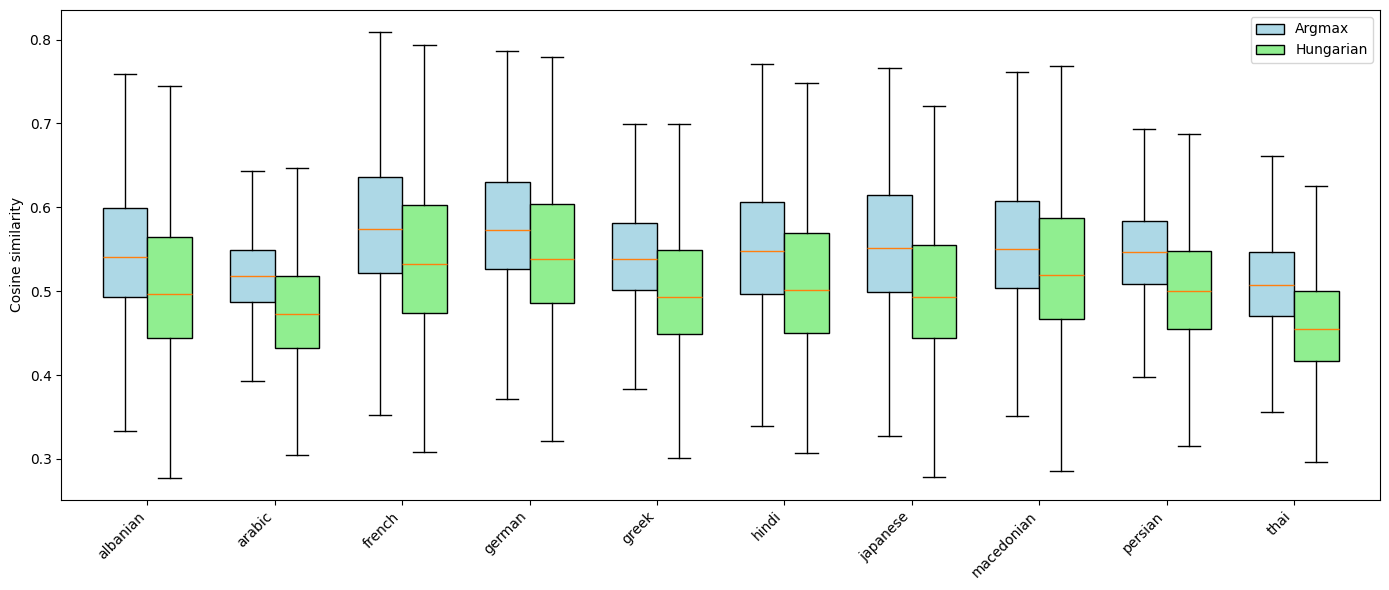

In [39]:
#| output: true
#| label: sim_distributions_plot
#| fig-cap: "Box plots comparing similarity distributions for Argmax and Competitive Linking methods across languages."

sim_distributions = collect_similarity_distributions(
    similarity_matrices,
    competitive_lexicons
)

plot_argmax_vs_hungarian(sim_distributions)

Across all languages, argmax consistently yields higher median and upper-range similarities, reflecting its greedy nature: it selects the strongest possible match for each source word, often reusing frequent English words. Competitive linking shows lower medians, confirming that enforcing one-to-one alignments limits the maximum achievable similarity scores ,as "hub" words cannot be reused. There seems not to be a significant difference between languages, the median values for both methods (around 0.5-0.6) are relatively consistent.

## Third alignement method: CCA-based mapping

The starting point is to load the bilingual lexicons from `MUSE` as well as the previously computed embeddings from `mBERT`. We will describe the pipeline for one language.

- Load the bilingual lexicon from `MUSE`.
- Filter to pairs covered by the precomputed mBERT word-type lexicons, and extract the corresponding embeddings to form aligned training matrices.
- Train a CCA model to learn linear projections for the two languages.
- Project all source and target word embeddings into the shared CCA space.
- Compute cosine similarity matrix in the CCA space.
- Repeat for all languages.

In [40]:
import numpy as np
from sklearn.cross_decomposition import CCA
from sklearn.metrics.pairwise import cosine_similarity

Building the aligned training matrices.

In [51]:
#| echo: true

def build_cca_training_data(src_lex, tgt_lex, gold_pairs):
    X, Y = [], []

    for src_w, tgt_w in gold_pairs:
        if src_w in src_lex and tgt_w in tgt_lex:
            X.append(src_lex[src_w])
            Y.append(tgt_lex[tgt_w])

    return np.array(X), np.array(Y)

Compute the CCA projections. Concerning the components, the documentation says: "number of components to keep. Should be in [1, min(n_samples, n_features, n_targets)]". So we do something similar by setting a fixed upper bound of 50 components and then clamping the actual number of components to the maximum value allowed by the data, namely the minimum of the number of gold pairs minus one and the embedding dimensionality.

In [ ]:
#| echo: true

def train_cca(X, Y, max_components=50):
    n_pairs, dim = X.shape
    n_components = min(max_components, n_pairs - 1, dim)
    cca = CCA(n_components=n_components, max_iter=2000)
    cca.fit(X, Y)
    return cca

In [ ]:
#| echo: true

def build_cca_similarity_matrix(src_lex, tgt_lex, cca):
    src_words = list(src_lex.keys())
    tgt_words = list(tgt_lex.keys())

    X = np.stack([src_lex[w] for w in src_words])
    Y = np.stack([tgt_lex[w] for w in tgt_words])

    # Project both vocabularies jointly into the CCA space
    Xp, Yp = cca.transform(X, Y)

    sim = cosine_similarity(Xp, Yp)
    return sim, src_words, tgt_words

Apply the pipeline for one language.

In [ ]:
#| echo: true

def cca_align_language(lang, lexicons_by_language, data, max_components=50, min_pairs=100):
    src_lex = lexicons_by_language[lang]["non_english"]
    tgt_lex = lexicons_by_language[lang]["english"]
    gold_pairs = data[lang]["lexicon"]

    X, Y = build_cca_training_data(src_lex, tgt_lex, gold_pairs)

    if X.shape[0] < min_pairs:
        print(f"Skipping {lang}: only {X.shape[0]} gold pairs")
        return None

    cca = train_cca(X, Y, max_components)
    return build_cca_similarity_matrix(src_lex, tgt_lex, cca)

... and for all languages.

In [ ]:
#| echo: true

def cca_align_all_languages(lexicons_by_language, data, max_components=50, min_pairs=100):
    cca_similarity_matrices = {}

    for lang in lexicons_by_language:
        print(f"Training CCA for {lang}")
        results = cca_align_language(
            lang,
            lexicons_by_language,
            data,
            max_components=max_components,
            min_pairs=min_pairs
        )

        if results is None:
            continue

        sim, src_words, tgt_words = results
        cca_similarity_matrices[lang] = {
            "matrix": sim,
            "non_english_words": src_words,
            "english_words": tgt_words
        }

    return cca_similarity_matrices

In [71]:
cca_similarity_matrices = cca_align_all_languages(
    emb_lexicons_by_language,
    data,
    max_components=50,
    min_pairs=100
)

Training CCA for albanian
Training CCA for arabic
Skipping arabic: only 4 gold pairs
Training CCA for french
Training CCA for german
Training CCA for greek
Skipping greek: only 1 gold pairs
Training CCA for hindi
Skipping hindi: only 2 gold pairs
Training CCA for japanese
Skipping japanese: only 0 gold pairs
Training CCA for macedonian
Skipping macedonian: only 10 gold pairs
Training CCA for persian
Skipping persian: only 4 gold pairs
Training CCA for thai
Skipping thai: only 6 gold pairs


Now we can build the lexicons in the CCA space and evaluate them using the same  hit@k method as before.

In [72]:
#| echo: true

argmax_caa_lexicons = build_lexicon(cca_similarity_matrices)

In [73]:
#| output: true
#| label: results_caa_k1
#| tbl-cap: "Results for CCA argmax evaluation across all languages."

results_cca = evaluate_all_languages(
    data,
    argmax_caa_lexicons
)

Markdown(results_cca.to_markdown(index=False))

| language   |        hit |
|:-----------|-----------:|
| albanian   | 0.00322573 |
| french     | 0.00987898 |
| german     | 0.00315783 |

The results are pretty terrible, but this has certainly to do with the very poor evaluation we have been using so far. We can perhaps use the `MUSE` lexicons as a gold standard for evaluation instead of the sentence-level co-occurrence method.

In [80]:
#| echo: true

def evaluate_lexicon_hit_at_k(induced_lexicon, muse_pairs, k=1):
    # Build gold lookup since MUSE may have multiple targets per source
    gold_lookup = {}
    for src, tgt in muse_pairs:
        gold_lookup.setdefault(src, set()).add(tgt)

    hits = 0
    total = 0

    for src_word, gold_targets in gold_lookup.items():
        if src_word not in induced_lexicon:
            continue

        predicted = induced_lexicon[src_word][:k]

        if any(tgt in gold_targets for tgt in predicted):
            hits += 1

        total += 1

    return hits / total if total > 0 else 0.0

In [83]:
import pandas as pd

def evaluate_caa_with_muse(argmax_cca_lexicons, data, k=1):
    rows = []

    for lang, lexicon in argmax_cca_lexicons.items():
        muse_pairs = data[lang]["lexicon"]

        # Wrap argmax predictions into lists to reuse the Hit@k logic
        wrapped_lexicon = {
            src: tgt if isinstance(tgt, list) else [tgt]
            for src, tgt in lexicon.items()
        }

        acc = evaluate_lexicon_hit_at_k(
            wrapped_lexicon,
            muse_pairs,
            k=k
        )

        rows.append({
            "language": lang,
            f"hit@{k}": acc,
            "n_gold": len(muse_pairs)
        })

    return pd.DataFrame(rows)

In [87]:
argmax_caa_lexicons5 = build_lexicon(cca_similarity_matrices, k=5)

In [ ]:
#| output: true
#| label: results_caa_detailed
#| tbl-cap: "Detailed results for CCA argmax evaluation across all languages."

detailed_results_cca = evaluate_caa_with_muse(
    argmax_caa_lexicons,
    data
)

Markdown(detailed_results_cca.to_markdown(index=False))

| language   |    hit@1 |   n_gold |
|:-----------|---------:|---------:|
| albanian   | 0.553191 |    11491 |
| french     | 0.698189 |    10872 |
| german     | 0.651899 |    14677 |

Yes, this is actually much better! Lets see with k=5.

In [90]:
#| output: true
#| label: results_caa_detailed2
#| tbl-cap: "Detailed results for CCA top 5 evaluation across all languages."

detailed_results_cca5 = evaluate_caa_with_muse(
    argmax_caa_lexicons5,
    data,
    k=5
)

Markdown(detailed_results_cca5.to_markdown(index=False))

| language   |    hit@5 |   n_gold |
|:-----------|---------:|---------:|
| albanian   | 0.553191 |    11491 |
| french     | 0.700201 |    10872 |
| german     | 0.651899 |    14677 |

There is only an improvement for French.